1. Importa las librerías necesarias y la base de datos, y realiza un análisis por variable
usando visualizaciones. Debes considerar las posibles correlaciones y representarlas
en un heatmap.


   Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls   
0      0           128                1         1        2.7              1  \
1      0           107                1         1        3.7              1   
2      0           137                1         0        0.0              0   
3      0            84                0         0        0.0              2   
4      0            75                0         0        0.0              3   

   DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
0    265.1       110           89.0        9.87      10.0  
1    161.6       123           82.0        9.78      13.7  
2    243.4       114           52.0        6.06      12.2  
3    299.4        71           57.0        3.10       6.6  
4    166.7       113           41.0        7.42      10.1  
Valores faltantes por columna:
 Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins

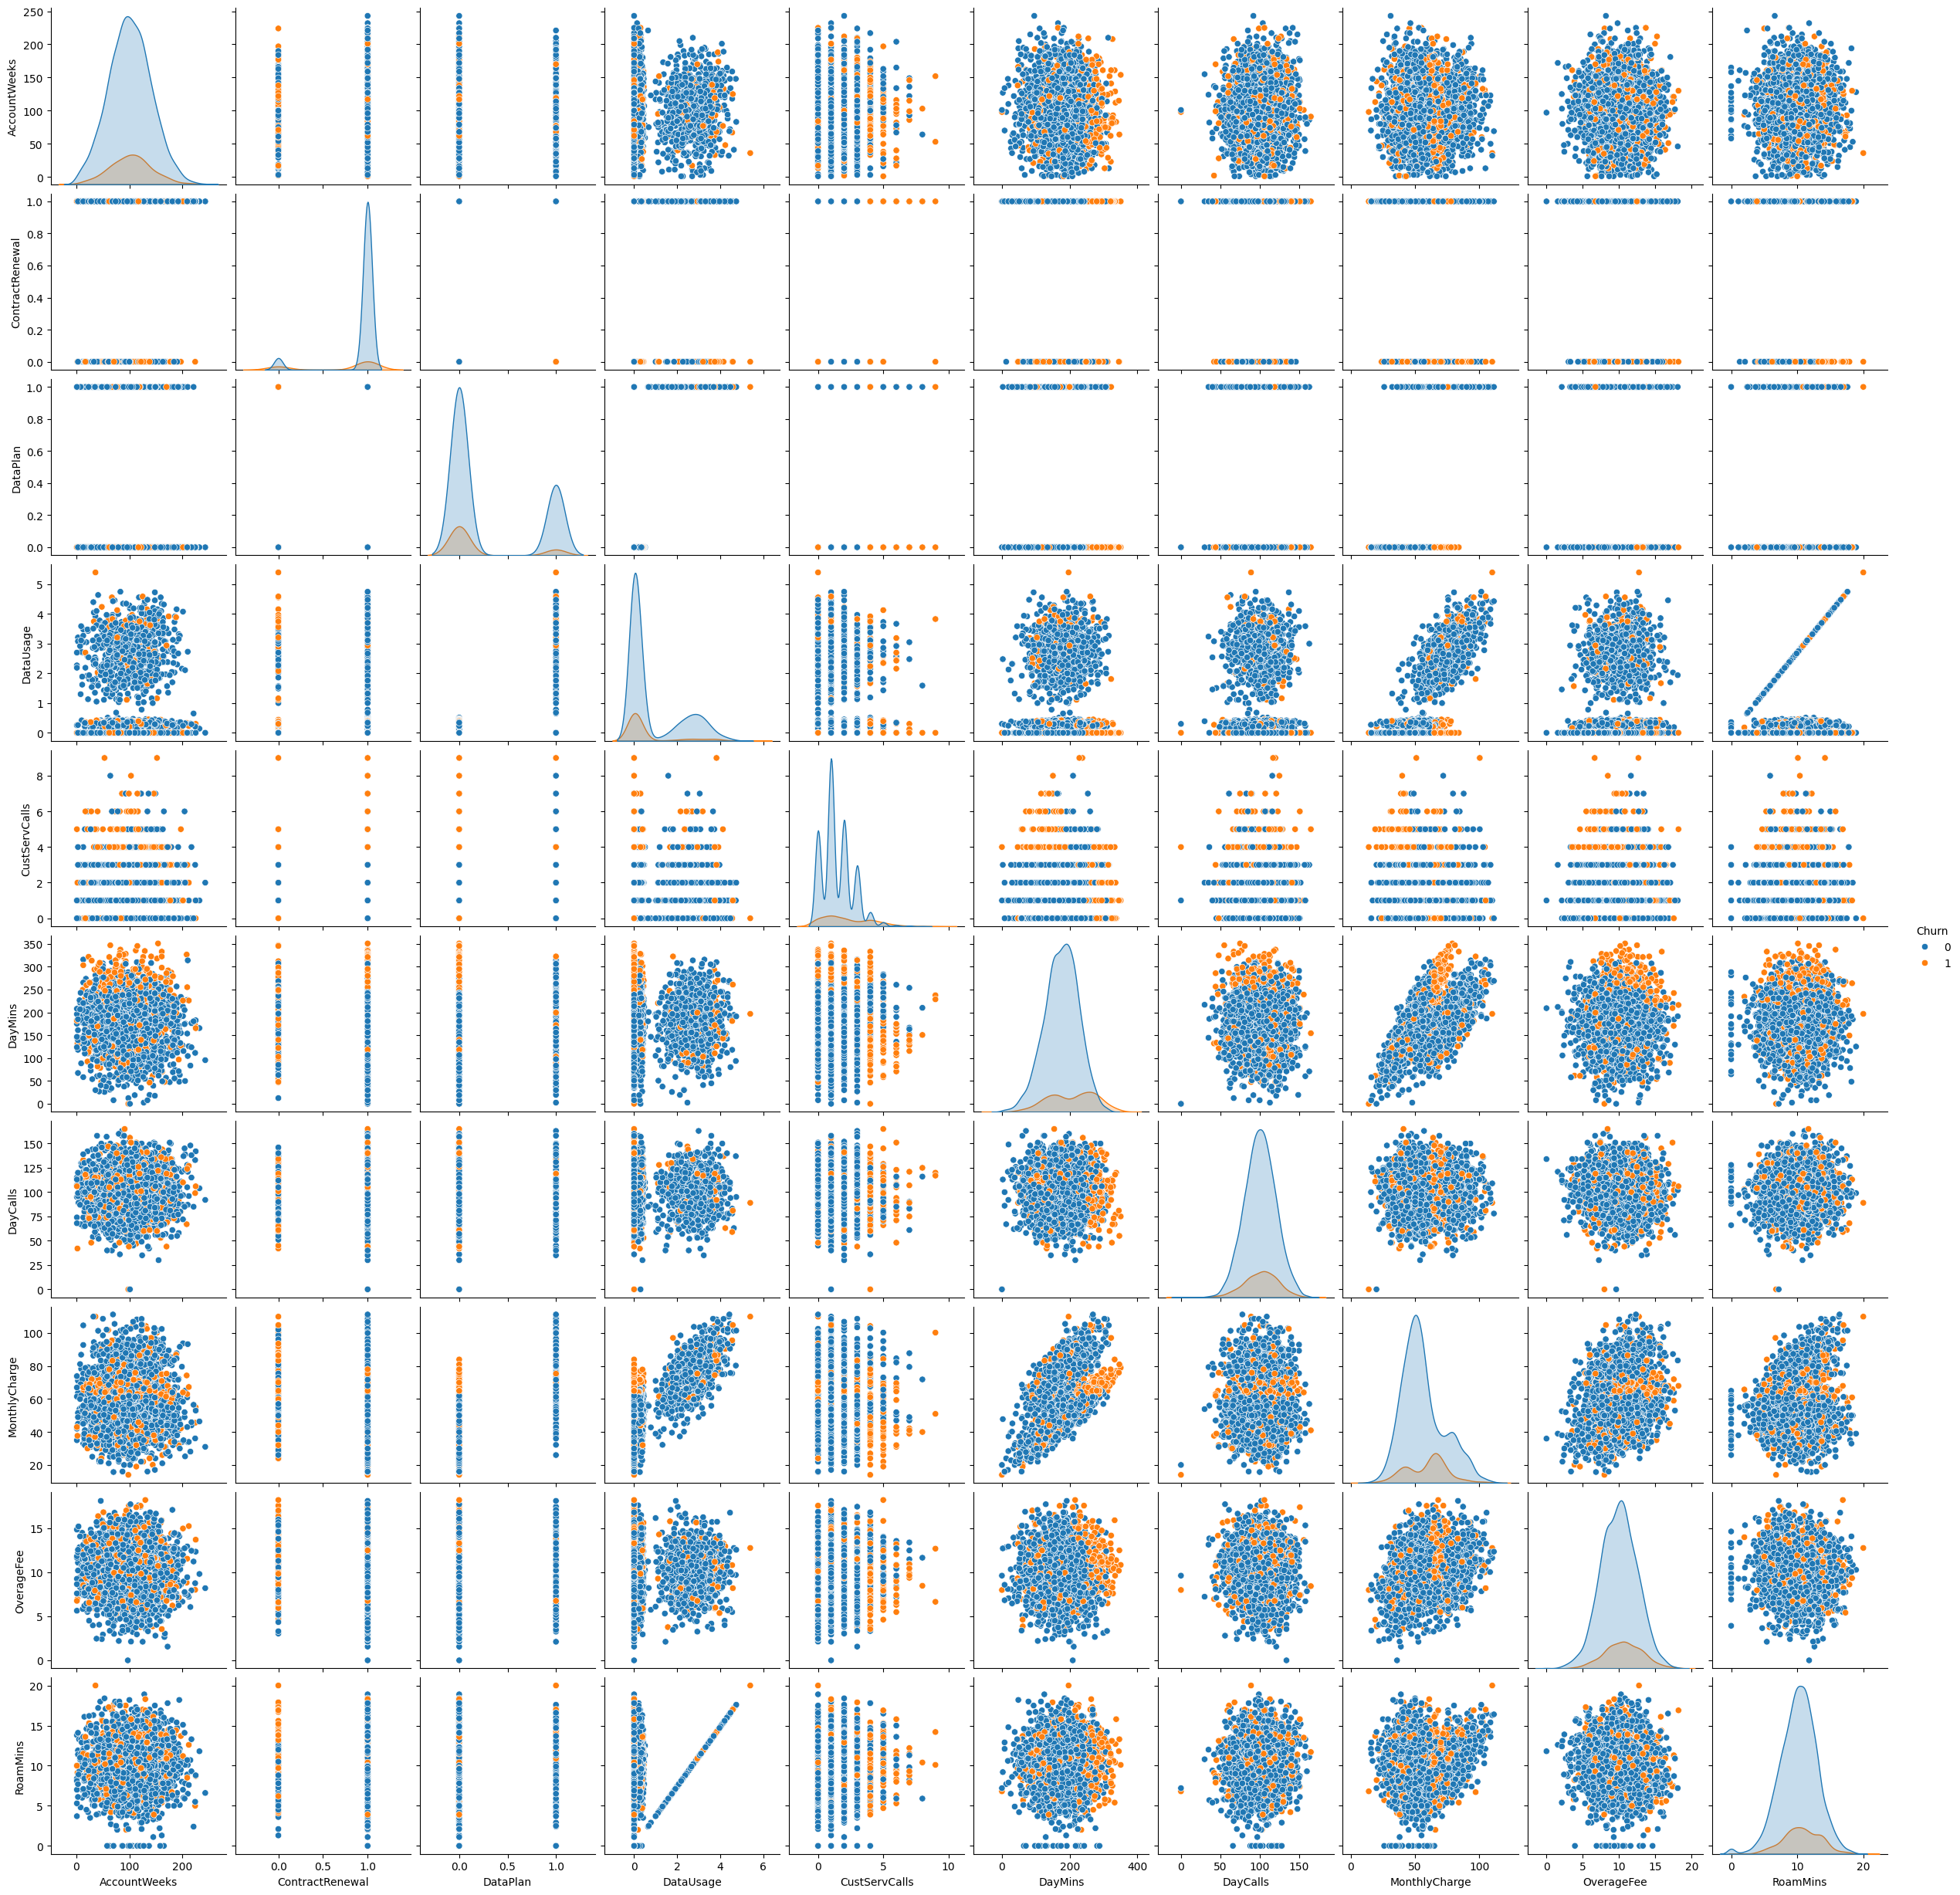

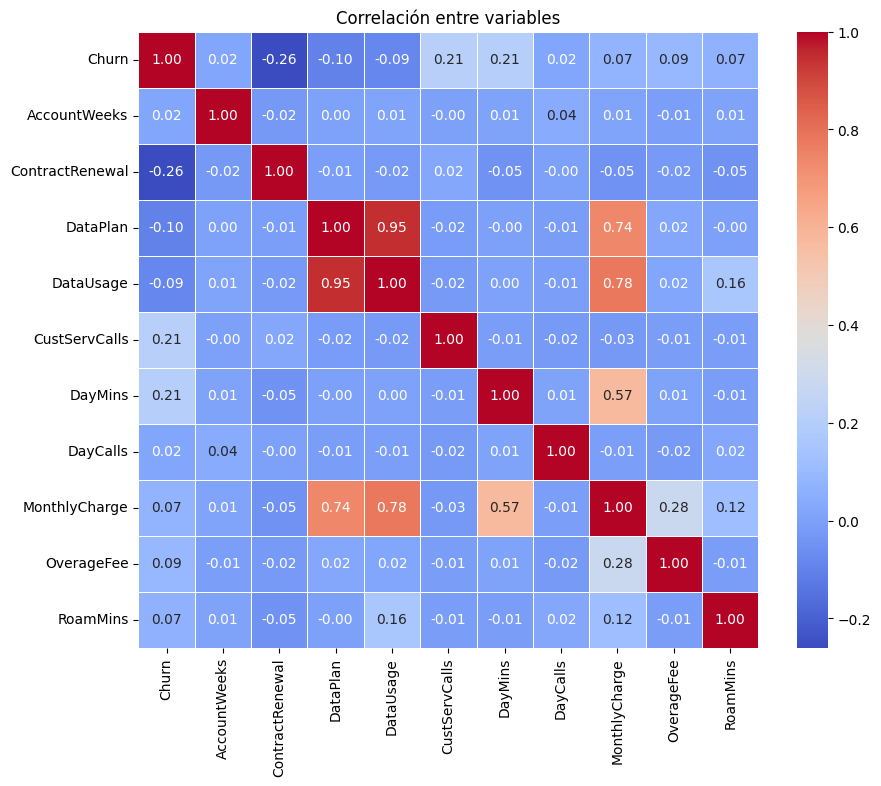

'Con las visualizaciones y el heatmap puedo deducir que: \nDataPlan y DataUsage: Una correlación alta de 0.95 indica que los clientes que tienen un plan de datos tienden a utilizar más datos mensualmente.\n\nMonthlyCharge y DataUsage: Una correlación de 0.78 sugiere que los clientes que utilizan más datos tienden a tener facturas mensuales más altas.\n\nDataPlan y MonthlyCharge: Una correlación de 0.74 indica que los clientes que tienen un plan de datos tienden a tener facturas mensuales más altas.\n\nDayMins y MonthlyCharge: Una correlación de 0.57 sugiere que los clientes que utilizan más minutos durante el día tienden a tener facturas mensuales más altas.'

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from util_bagging import bagging_het, bagging_het_predict

#FernandoSanchez Cargar los datos desde el archivo CSV
data = pd.read_csv("telecom_churn.csv")

#FernandoSanchez Mostrar las primeras filas del dataframe para verificar la carga correcta
print(data.head())

#FernandoSanchez Verificar si hay valores faltantes en el conjunto de datos
missing_values = data.isna().sum()

#FernandoSanchez Mostrar el número de valores faltantes por columna
print("Valores faltantes por columna:\n", missing_values)

#FernandoSanchez Visualización de las distribuciones de las variables numéricas
sns.pairplot(data, hue='Churn', diag_kind='kde')
plt.show()

#FernandoSanchez Calculamos las correlaciones entre las variables
correlation_matrix = data.corr()

#FernandoSanchez Visualizamos las correlaciones en un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlación entre variables")
plt.show()

"""Con las visualizaciones y el heatmap puedo deducir que: 
DataPlan y DataUsage: Una correlación alta de 0.95 indica que los clientes que tienen un plan de datos tienden a utilizar más datos mensualmente.

MonthlyCharge y DataUsage: Una correlación de 0.78 sugiere que los clientes que utilizan más datos tienden a tener facturas mensuales más altas.

DataPlan y MonthlyCharge: Una correlación de 0.74 indica que los clientes que tienen un plan de datos tienden a tener facturas mensuales más altas.

DayMins y MonthlyCharge: Una correlación de 0.57 sugiere que los clientes que utilizan más minutos durante el día tienden a tener facturas mensuales más altas."""

2. Desarrolla un modelo de árbol de decisión sin modificar sus hiper parámetros y
despliega sus métricas de desempeño. Luego, mejora este modelo de forma de
evitar el overfitting usando búsqueda por grilla con 5 kfold:
max_depth: [5, 10, 15, 20, 25]
min_samples_split: [0.01, 0.02, 0.03, 0.04]
Da a conocer los mejores hiper parámetros encontrados y el desempeño del modelo,
tanto en los datos de entrenamiento como en los de test.

In [20]:
#FernandoSanchez Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data.drop('Churn', axis=1), data['Churn'], test_size=0.2, random_state=42)

#FernandoSanchez Inicializar y entrenar el modelo de árbol de decisión
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

#FernandoSanchez Predecir sobre los datos de prueba
y_pred = tree_model.predict(X_test)

#FernandoSanchez Calcular y mostrar métricas de desempeño
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

"""Para la clase "0" (no churn), el modelo tiene una precisión del 92% y una sensibilidad (recall) del 93%. 
Esto indica que el modelo predice correctamente el 92% de los casos de no churn y captura correctamente el 93% de todos los casos reales de no churn en los datos de prueba.
Para la clase "1" (churn), el modelo tiene una precisión del 59% y una sensibilidad del 57%. 
Esto indica que el modelo predice correctamente el 59% de los casos de churn y captura correctamente el 57% de todos los casos reales de churn en los datos de prueba.
El valor F1-score, que es una medida ponderada de la precisión y el recall, es de aproximadamente 0.93 para la clase "0" y 0.58 para la clase "1"."""

#FernandoSanchez Definir los hiperparámetros a ajustar
param_grid = {
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [0.01, 0.02, 0.03, 0.04]
}

#FernandoSanchez Inicializar el modelo de árbol de decisión
tree_model = DecisionTreeClassifier(random_state=42)

#FernandoSanchez Inicializar la búsqueda por grilla con validación cruzada
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

#FernandoSanchez Ejecutar la búsqueda por grilla en los datos de entrenamiento
grid_search.fit(X_train, y_train)

#FernandoSanchez Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros encontrados:", best_params)

#FernandoSanchez Evaluar el desempeño del mejor modelo en los datos de prueba
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

#FernandoSanchez Calcular y mostrar métricas de desempeño del mejor modelo
accuracy_best = accuracy_score(y_test, y_pred_best)
print("\nAccuracy del mejor modelo:", accuracy_best)
print("\nClassification Report del mejor modelo:")
print(classification_report(y_test, y_pred_best))

"""Los mejores hiperparámetros encontrados para el modelo de árbol de decisión son:

Profundidad máxima del árbol (max_depth): 5
Mínimo número de muestras requeridas para dividir un nodo interno (min_samples_split): 0.03
Para la clase "0" (no churn), el modelo tiene una precisión del 92% y una sensibilidad del 98%. 
Esto indica que el modelo predice correctamente el 92% de los casos de no churn y captura correctamente el 98% de todos los casos reales de no churn en los datos de prueba.
Para la clase "1" (churn), el modelo tiene una precisión del 85% y una sensibilidad del 50%. 
Esto indica que el modelo predice correctamente el 85% de los casos de churn y captura correctamente el 50% de todos los casos reales de churn en los datos de prueba.
El valor F1-score, que es una medida ponderada de la precisión y el recall, es de aproximadamente 0.95 para la clase "0" y 0.63 para la clase "1"."""

Accuracy: 0.8755622188905547

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       566
           1       0.59      0.57      0.58       101

    accuracy                           0.88       667
   macro avg       0.76      0.75      0.75       667
weighted avg       0.87      0.88      0.87       667

Mejores hiperparámetros encontrados: {'max_depth': 5, 'min_samples_split': 0.03}

Accuracy del mejor modelo: 0.9115442278860569

Classification Report del mejor modelo:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       566
           1       0.85      0.50      0.63       101

    accuracy                           0.91       667
   macro avg       0.88      0.74      0.79       667
weighted avg       0.91      0.91      0.90       667



'Los mejores hiperparámetros encontrados para el modelo de árbol de decisión son:\n\nProfundidad máxima del árbol (max_depth): 5\nMínimo número de muestras requeridas para dividir un nodo interno (min_samples_split): 0.03\nPara la clase "0" (no churn), el modelo tiene una precisión del 92% y una sensibilidad del 98%. \nEsto indica que el modelo predice correctamente el 92% de los casos de no churn y captura correctamente el 98% de todos los casos reales de no churn en los datos de prueba.\nPara la clase "1" (churn), el modelo tiene una precisión del 85% y una sensibilidad del 50%. \nEsto indica que el modelo predice correctamente el 85% de los casos de churn y captura correctamente el 50% de todos los casos reales de churn en los datos de prueba.\nEl valor F1-score, que es una medida ponderada de la precisión y el recall, es de aproximadamente 0.95 para la clase "0" y 0.63 para la clase "1".'

3. Balancea las clases usando SMOTE para el conjunto de entrenamiento. Luego, aplica
un modelo de Bagging con 200 estimadores y muestra las métricas sobre el conjunto
de test.


In [21]:

#FernandoSanchez Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

#FernandoSanchez Estandarizar las características
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test = scaler.transform(X_test)

#FernandoSanchez Definir el modelo de árbol de decisión con los parámetros encontrados
tree_model = DecisionTreeClassifier(max_depth=5, min_samples_split=0.03, random_state=42)

#FernandoSanchez Inicializar y entrenar un modelo de Bagging con el modelo de árbol de decisión
bagging_model = BaggingClassifier(estimator=tree_model, n_estimators=200, random_state=42, bootstrap=True, bootstrap_features=False)
bagging_model.fit(X_train_balanced, y_train_balanced)

#FernandoSanchez Evaluar el modelo de Bagging en los datos de prueba
y_pred_bagging = bagging_model.predict(X_test)
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print("Accuracy del modelo de Bagging:", accuracy_bagging)
print("\nClassification Report del modelo de Bagging:")
print(classification_report(y_test, y_pred_bagging))

"""El modelo de Bagging con el árbol de decisión como estimador base obtuvo un buen rendimiento. 
Aunque la precisión para la clase 1 es relativamente baja, el modelo logra un buen equilibrio entre precisión y recall para ambas clases"""

Accuracy del modelo de Bagging: 0.8830584707646177

Classification Report del modelo de Bagging:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       566
           1       0.58      0.80      0.68       101

    accuracy                           0.88       667
   macro avg       0.77      0.85      0.80       667
weighted avg       0.90      0.88      0.89       667



'El modelo de Bagging con el árbol de decisión como estimador base obtuvo un buen rendimiento. \nAunque la precisión para la clase 1 es relativamente baja, el modelo logra un buen equilibrio entre precisión y recall para ambas clases'

4. Implementa un modelo de Bagging usando modelos heterogéneos con los
siguientes estimadores: Regresión Logística, Árbol de decisión, y dos SVM de
clasificación con kernel ‘rbf’ y ‘sigmoid’. Para ello considera 200 muestras bootstrap
(T).
Debes calibrar la importancia de los modelos, repitiendo el modelo que sea más
importante en la lista de modelos a entrenar. Considera que un mejor modelo es
aquel con mejor f1-score. Muestra las métricas del modelo final aplicado al conjunto
de test. (Para realizar esta tarea utiliza la función bagging_het que se encuentra en el
archivo util_bagging.py)


In [28]:
#FernandoSanchez Regresión Logística
logistic_params = {
    'max_iter': [1000, 2000],
    'solver': ['liblinear', 'saga'],
    'C': [0.1, 1.0, 10.0]
}

logistic_grid = GridSearchCV(LogisticRegression(random_state=42), logistic_params, cv=5, scoring='f1')
logistic_grid.fit(X_train_balanced, y_train_balanced)

best_logistic_model = logistic_grid.best_estimator_
print("Best Logistic Regression Model:", best_logistic_model)

#FernandoSanchez SVM (Kernel RBF)
svm_rbf_params = {
    'C': [0.1, 1.0, 10.0],
    'gamma': ['auto', 'scale', 0.1, 1.0, 10.0]
}

svm_rbf_grid = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=42), svm_rbf_params, cv=5, scoring='f1')
svm_rbf_grid.fit(X_train_balanced, y_train_balanced)

best_svm_rbf_model = svm_rbf_grid.best_estimator_
print("Best SVM (RBF) Model:", best_svm_rbf_model)

#FernandoSanchez SVM (Kernel Sigmoid)
svm_sigmoid_params = {
    'C': [0.1, 1.0, 10.0],
    'gamma': ['auto', 'scale', 0.1, 1.0, 10.0],
    'coef0': [0.0, 0.1, 1.0]
}

svm_sigmoid_grid = GridSearchCV(SVC(kernel='sigmoid', probability=True, random_state=42), svm_sigmoid_params, cv=5, scoring='f1')
svm_sigmoid_grid.fit(X_train_balanced, y_train_balanced)

best_svm_sigmoid_model = svm_sigmoid_grid.best_estimator_
print("Best SVM (Sigmoid) Model:", best_svm_sigmoid_model)


Best Logistic Regression Model: LogisticRegression(C=10.0, max_iter=1000, random_state=42, solver='liblinear')
Best SVM (RBF) Model: SVC(C=10.0, gamma=1.0, probability=True, random_state=42)
Best SVM (Sigmoid) Model: SVC(C=0.1, kernel='sigmoid', probability=True, random_state=42)


In [29]:
#FernandoSanchez Modelos heterogéneos
estimators = [('Logistic Regression', LogisticRegression(C=10.0, max_iter=1000, random_state=42, solver='liblinear')),
              ('Decision Tree', DecisionTreeClassifier(max_depth=5, min_samples_split=0.03, random_state=42)),
              ('SVM RBF', SVC(C=10.0, gamma=1.0, probability=True, kernel='rbf', random_state=42)),
              ('SVM Sigmoid', SVC(C=0.1, kernel='sigmoid', probability=True, random_state=42))]


#FernandoSanchez Modelos heterogéneos
estimators = [estimator for _, estimator in estimators]

#FernandoSanchez Convertir X_train_balanced a DataFrame de pandas con nombres de columnas
X_train_balanced_df = pd.DataFrame(X_train_balanced, columns=X_train.columns)

#FernandoSanchez Entrenar el modelo Bagging con modelos heterogéneos
trained_models, yhat_test, yhat_out, _ = bagging_het(X_train_balanced_df, y_train_balanced, 200, estimators, X_test)

#FernandoSanchez Mostrar métricas del modelo Bagging con modelos heterogéneos
print("\nMétricas del modelo de Bagging con modelos heterogéneos:")
print(classification_report(y_test, yhat_out))








"""Lo trate con BaggingClassifier y funciono bien, estuve tratando con util_bagging pero manda advertencias de nombres a veces, a veces no esta muy raro,
busque el error y dice que es porque paso np.arrays los pase a dataframes y sigue el error."""

C:\Users\Fernando Sanchez\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Fernando Sanchez\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Fernando Sanchez\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\Fernando Sanchez\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\Fernando Sanchez\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Dec

KeyboardInterrupt: 

5. Implementa un modelo de ensamble Random Forest usando como hiper parámetro
n_estimators = 45. El modelo debe usar muestra OOB para estimar su ajuste
ACCURACY, y debe mostrar las cuatro características más importantes junto con las
métricas de desempeño en el conjunto de test.

In [16]:
#FernandoSanchez Inicializar y entrenar el modelo de Random Forest
random_forest_model = RandomForestClassifier(n_estimators=45, oob_score=True, random_state=42)
random_forest_model.fit(X_train_balanced, y_train_balanced)

#FernandoSanchez Predecir sobre los datos de prueba
y_pred_random_forest = random_forest_model.predict(X_test)

#FernandoSanchez Calcular métricas de desempeño
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
print("\nAccuracy del modelo de Random Forest:", accuracy_random_forest)
print("\nClassification Report del modelo de Random Forest:")
print(classification_report(y_test, y_pred_random_forest))

#FernandoSanchez Características más importantes
feature_importances = random_forest_model.feature_importances_
important_features_indices = np.argsort(feature_importances)[::-1][:4]
important_features = data.columns[important_features_indices]
print("\nCuatro características más importantes:")
for feature in important_features:
    print(feature)

"""El modelo de Random Forest tiene una precisión global (accuracy) de aproximadamente 0.896, 
lo que indica que el 89.6% de las predicciones son correctas. 
En cuanto al informe de clasificación, podemos ver que el modelo tiene un buen rendimiento en la clasificación de la clase 0 (clientes que no cancelaron el servicio), 
con una precisión, recall y f1-score de 0.96, 0.92 y 0.94 respectivamente. Sin embargo, el rendimiento en la clasificación de la clase 1 (clientes que cancelaron el servicio) 
es inferior, con una precisión de 0.63, recall de 0.76 y f1-score de 0.69.

Las cuatro características más importantes para el modelo son:

AccountWeeks
DayCalls
CustServCalls
DataUsage"""


Accuracy del modelo de Random Forest: 0.896551724137931

Classification Report del modelo de Random Forest:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       566
           1       0.63      0.76      0.69       101

    accuracy                           0.90       667
   macro avg       0.79      0.84      0.81       667
weighted avg       0.91      0.90      0.90       667


Cuatro características más importantes:
AccountWeeks
DayCalls
CustServCalls
DataUsage


6. Realiza una búsqueda de grilla para un modelo Random Forest para los siguientes
rangos de valores para sus hiper parámetros:
n_estimators: 50 - 200 con paso de 10 completando 15 valores
max_features: [‘sqrt’, ‘log2’, None]
Muestra los mejores hiper parámetros encontrados, la estimación de desempeño en
los datos OOB, y despliega los cuatro atributos más importantes. ¿Tienen sentido
estos? Analiza además las métricas de desempeño, ROC y AUC.


In [32]:
# Definir los hiperparámetros a buscar
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_features': ['sqrt', 'log2']
}


# Crear el modelo de Random Forest con oob_score=True
rf_model = RandomForestClassifier(oob_score=True, random_state=42)

# Realizar la búsqueda de hiperparámetros
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

# Mejores hiperparámetros encontrados
best_params_rf = grid_search_rf.best_params_
print("\nMejores hiperparámetros encontrados para Random Forest:", best_params_rf)

# Estimación de desempeño en datos OOB
oob_accuracy = grid_search_rf.best_estimator_.oob_score_
print("\nEstimación de desempeño en datos OOB:", oob_accuracy)

# Características más importantes
feature_importances_rf = grid_search_rf.best_estimator_.feature_importances_
important_features_indices_rf = np.argsort(feature_importances_rf)[::-1][:4]
important_features_rf = data.columns[important_features_indices_rf]
print("\nCuatro características más importantes según Random Forest:")
for feature in important_features_rf:
    print(feature)
"""Además, la estimación del desempeño en datos Out-of-Bag (OOB) es del 93.96%.

Las cuatro características más importantes identificadas por el modelo de Random Forest son:

CustServCalls (Llamadas al Servicio al Cliente)
DayCalls (Llamadas de Día)
DataUsage (Uso de Datos)
MonthlyCharge (Carga Mensual)"""


Mejores hiperparámetros encontrados para Random Forest: {'max_features': 'sqrt', 'n_estimators': 150}

Estimación de desempeño en datos OOB: 0.9396099024756189

Cuatro características más importantes según Random Forest:
CustServCalls
DayCalls
DataUsage
MonthlyCharge


7. Usando el modelo Random Forest con sus hiper parámetros ajustados, muestre los
15 clientes que presentan la mayor propensión a renunciar.

In [36]:
# Convertir X_test a un DataFrame de pandas
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# Calcular las probabilidades de renuncia con el modelo de Random Forest
churn_probabilities = random_forest_model.predict_proba(X_test_df)[:, 1]

# Crear un DataFrame con el índice de X_test
index_df = pd.DataFrame({'CustomerID': X_test_df.index})

# Crear un DataFrame con las probabilidades de renuncia
churn_prob_df = pd.DataFrame({'Churn Probability': churn_probabilities})

# Concatenar ambos DataFrames a lo largo de las columnas
churn_predictions_df = pd.concat([index_df, churn_prob_df], axis=1)

# Ordenar los clientes por probabilidad de renuncia en orden descendente
top_churners = churn_predictions_df.sort_values(by='Churn Probability', ascending=False).head(15)

# Mostrar los 15 clientes con mayor probabilidad de renuncia
print("\nLos 15 clientes con mayor probabilidad de renunciar:")
print(top_churners)




Los 15 clientes con mayor probabilidad de renunciar:
     CustomerID  Churn Probability
397         397           1.000000
640         640           1.000000
647         647           1.000000
297         297           1.000000
491         491           1.000000
91           91           1.000000
187         187           1.000000
661         661           1.000000
415         415           1.000000
570         570           1.000000
305         305           1.000000
229         229           1.000000
254         254           0.977778
270         270           0.977778
420         420           0.977778


C:\Users\Fernando Sanchez\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
